In [35]:
# Imports 
import numpy as np
import pandas as pd
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import ipywidgets
import warnings
warnings.filterwarnings("ignore")
import scipy.interpolate
from IPython.display import display, Javascript
import os
import shutil

def getNotebookName():
    display(Javascript('IPython.notebook.kernel.execute("theNotebook = \'"+IPython.notebook.notebook_name+"\'");'))
    return theNotebook

cst = tp.cst()
twopi = 2 * np.pi
kHz = 1e3 * cst.h

In [3]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [4]:
# Function 
def movie_pad(data, xpad=True, ypad=True, xshift=False, yshift=False):
    x, y, z = data
    if xpad: x = np.concatenate([x, [x[-1] + np.diff(x)[-1]]])
    if ypad: y = np.concatenate([y, [y[-1] + np.diff(y)[-1]]])
    return (x, y, z)

# Load Data from Images

In [180]:
df_all = pd.DataFrame()

In [181]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)']
usei = 0
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [182]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)

A Jupyter Widget


Total Number of Shots 93, Images 93


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,HeatTime,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x
name,,,,,,,,,,,,,,,,,,,
09-13-2017_19_14_37_TopA,0,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,20.0,0.0,20.0,0.0,140.0,0.20,0.0,None,140.0
09-13-2017_19_15_31_TopA,0.9,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,20.0,0.0,20.0,0.0,140.0,0.20,0.0,None,140.0
09-13-2017_19_18_24_TopA,3.78333,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,20.0,0.0,20.0,20.0,100.0,0.25,200.0,None,100.0


In [183]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.1, radial_selection=0.75,)}

In [184]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))

A Jupyter Widget

In [185]:
# Start Saving Folder 
savefig = ipywidgets.Checkbox(value=False, description='Save Figs')
display(savefig)
folder_name = df_all.iloc[0].name[0:17] + 'BoxShaking'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix_samples = os.path.join(folder_name, 'Samples','')
os.makedirs(os.path.join(folder_name, 'Samples'), exist_ok=True)
suffix

A Jupyter Widget

'09-13-2017_19_14_BoxShaking/'

In [186]:
# Define backgrounds 
background_parameter = 'ShakingCycles'
background_value = 0
df_all['bg'] = df_all[background_parameter] == background_value

A Jupyter Widget


Total Images 93 ==> Good 88, Bad 5


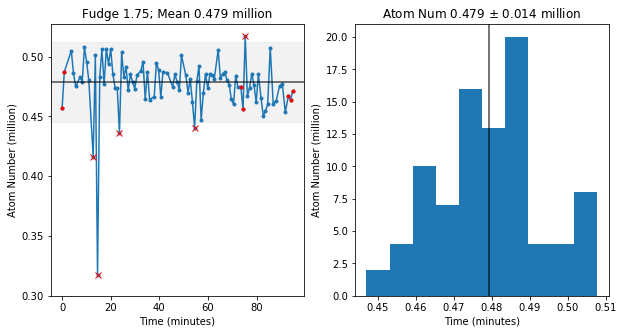

In [187]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.07, offset=0.0, display=True, plot=True)
ax[0].set(ylim=[0.3,None])
ax[0].plot(df_all.loc[df_all['bg'], 'time'], df_all.loc[df_all['bg'], 'total_atoms']/1e6, 'r.')
if savefig.value: plt.savefig(suffix + 'AtomNumbersScatter.pdf')
df = df_all[df_all.use]

[  50.   55.   60.   65.   69.   70.   71.   72.   73.   74.   75.   76.
   77.   78.   80.   85.   90.   95.  100.  110.  120.  125.  130.  135.
  140.  145.  150.  155.  160.  165.  170.  180.  190.  200.  210.  220.
  230.  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.
  350.  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  470.
  480.  490.  500.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  620.  640.  660.  680.  700.]


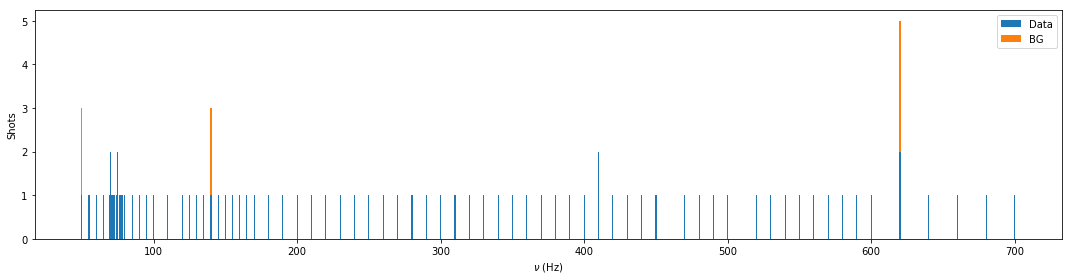

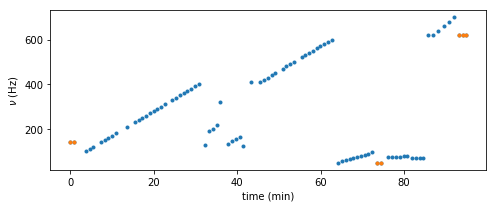

In [188]:
# Dataset Explorer 
def dataset_counter(df, bg_param='bg', bg_value=True, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter, ax

ds_counter, ax = dataset_counter(df=df, plot=True, xlabel=x_var_label)
if savefig.value: ax.figure.savefig(suffix + 'DatasetCounter_vsX.pdf')
print(np.unique(df.x.values))
plt.figure(figsize = [7, 3])
plt.plot(df.time, df.x, '.')
bgi = df[background_parameter] == background_value
plt.plot(df.time[bgi], df.x[bgi], '.')
plt.xlabel('time (min)')
plt.ylabel(x_var_label)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'DatasetCounter_vsTime.pdf')

A Jupyter Widget

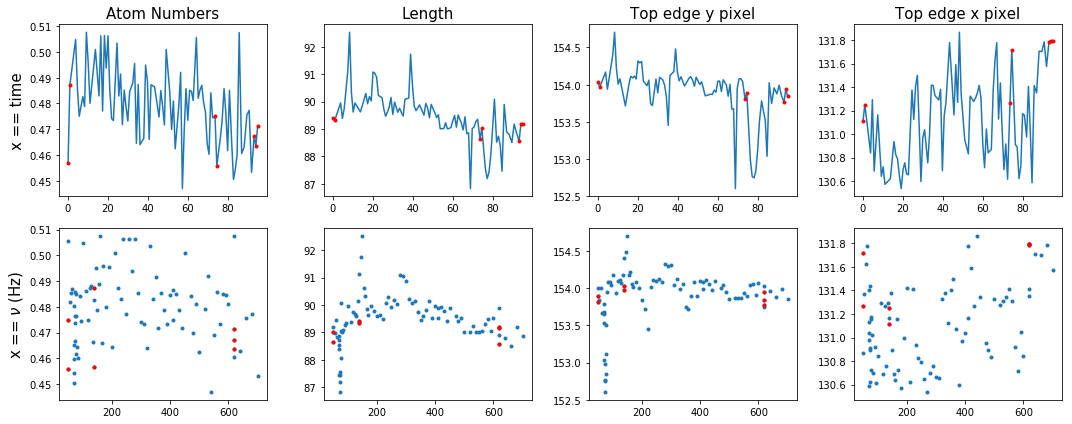

In [189]:
# Box Length and Center 
df['nz_raw'] = [im.nz for im in tqdm(df.image)]
df['pz_raw'] = [tp.Curve(x = nz.x, y = np.arange(len(nz.x))) for nz in df['nz_raw']]
df['xsec_raw'] = [im.xsec for im in df.image]
guess_ = [-45e-6, 45e-6, 5e-6, 5e-6]
df['box_fit'] = [tp.curve_fit(tp.erf_box, guess_ + [nz.maxy, nz.maxy/1e3], *nz.data, ) for nz in df['nz_raw']]
df['length'] = [f[1] - f[0] for f in df['box_fit']]
df['top_ypixel'] = [r['pz_raw'](r['box_fit'].fv[1]) for n,r in df.iterrows()]
df['top_xpixel'] = [r['xsec_raw'].get_center(r['top_ypixel']) for n,r in df.iterrows()]
df['bottom_ypixel'] = [r['pz_raw'](r['box_fit'].fv[0]) for n,r in df.iterrows()]
df['bottom_xpixel'] = [r['xsec_raw'].get_center(r['bottom_ypixel']) for n,r in df.iterrows()]
df['center_ypixel'] = [r['pz_raw']((r['box_fit'].fv[0] + r['box_fit'].fv[1])/2) for n,r in df.iterrows()]
df['center_xpixel'] = [r['xsec_raw'].get_center(r['center_ypixel']) for n,r in df.iterrows()]
df['nz_fixed'] = [tp.Curve(x = r.nz_raw.x, y = r.nz_raw.y - r.box_fit(amp=0), xscale=1e-6, yscale=1e18) for n,r in df.iterrows()]
df['nz_integral'] = [np.trapz(c.y, c.x) for c in df['nz_fixed']]

# Plot test 
ax = plt.subplots(ncols=4, nrows=2, figsize=[15, 6])[1].flatten()
bgi = df[background_parameter] == background_value

ax[0].plot(df['time'], df['total_atoms']/1e6)
ax[1].plot(df['time'], df['length']*1e6)
ax[2].plot(df['time'], df['top_ypixel'])
ax[3].plot(df['time'], df['top_xpixel'])

ax[0].plot(df.loc[bgi, 'time'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[1].plot(df.loc[bgi, 'time'], df.loc[bgi, 'length']*1e6, 'r.')
ax[2].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[3].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_xpixel'], 'r.')

ax[4].plot(df['x'], df['total_atoms']/1e6, '.')
ax[5].plot(df['x'], df['length']*1e6, '.')
ax[6].plot(df['x'], df['top_ypixel'], '.')
ax[7].plot(df['x'], df['top_xpixel'], '.')

ax[4].plot(df.loc[bgi, 'x'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[5].plot(df.loc[bgi, 'x'], df.loc[bgi, 'length']*1e6, 'r.')
ax[6].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[7].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_xpixel'], 'r.')

ax[0].set_title('Atom Numbers', fontsize=15)
ax[1].set_title('Length', fontsize=15)
ax[2].set_title('Top edge y pixel', fontsize=15)
ax[3].set_title('Top edge x pixel', fontsize=15)
ax[0].set_ylabel(r'x == time', fontsize=15)
ax[4].set_ylabel(r'x == {}'.format(x_var_label), fontsize=15)

plt.tight_layout()

if savefig.value: plt.savefig(suffix + 'DatasetQuality.pdf')

In [190]:
# Test box fit 
size = 80
test = 0
def temp(test=np.random.randint(df.shape[0])):
    r = df.iloc[test]
    roi = tp.get_roi(r.image.app, width=size, height=size)
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plt.sca(ax[0])
    plt.imshow(r.image.app)
    plt.colorbar()
    plt.title('Atoms per binned Pixel', fontsize=15)
    plt.plot(r.xsec_raw.get_center(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_left(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_right(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.axhline(r.top_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.axhline(r.bottom_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.plot([r.top_xpixel, r.bottom_xpixel, r.center_xpixel], [r.top_ypixel, r.bottom_ypixel, r.center_ypixel], 'ow')
    ax[0].set(xlim=[roi[1].start, roi[1].stop], ylim=[roi[0].start, roi[0].stop])
    ax[1].plot(*r.nz_raw.plotdata)
    ax[1].plot(r.box_fit.xp * 1e6, r.box_fit(r.box_fit.xp) / 1e18, alpha=0.8)
    ax[1].axvline(r.box_fit[0]*1e6, c='k', linestyle='--',)
    ax[1].axvline(r.box_fit[1]*1e6, c='k', linestyle='--',)
    ax[1].set(xlim=[-150, 150])
    image_kind = 'BG' if r[background_parameter] == background_value else 'Image'
    ax[1].set_title('{} : {}; {} = {}'.format(image_kind, r.name, x_var_label, r.x), fontsize=15)
    ax[1].set_ylabel(r'$n$ $(\mu m^{-3})$', fontsize=15)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'BoxFitsSamples_{}_{}.pdf'.format(r.x, r.name))
    plt.show()
if df.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df.shape[0]-1))

A Jupyter Widget

In [191]:
# IMPORTANT SETTINGS 
shared_background = True 
proper_center = 'center' # top or center or bottom or none 
zero_z = 'center' # where to put the zero for z top, bottom, center 

In [192]:
# Begin df_data and allocate images 
threshold_image_num = 1

# use dataset with enough images only
if shared_background == False:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and (ds_counter[2][i] >= threshold_image_num)]
elif shared_background == True:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and ds_counter[2].sum() >= threshold_image_num]
df_data = pd.DataFrame(index = xlist)

# Compute things 
df_data['data_ind'] = [(df.x == x) & (~ df['bg']) for x in df_data.index.values]
df_data['# data'] = [np.sum(t) for t in df_data['data_ind']]
df_data['bg_ind'] = [((df.x == x) | ~shared_background) & (df['bg']) for x in df_data.index.values]
df_data['# bg'] = [np.sum(t) for t in df_data['bg_ind']]
df_data['length'] = [np.mean(df.loc[ind,'length']) for ind in df_data['bg_ind']]
df_data['freq'] = [df.loc[ind,'BoxShakeFreq'].iloc[0] for ind in df_data['data_ind']]
df_data['cycles'] = [df.loc[ind,'ShakingCycles'].iloc[0] for ind in df_data['data_ind']]

# Start dict_data 
dict_data = {}

In [193]:
# Calculate proper n(z) for each item in df 

# calculate proper length and density rescaling factor 
df['proper_length'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'length']) 
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'length']) 
                       for n,r in df.iterrows()]
df['proper_nrescale'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'nz_integral']) / r['nz_integral']
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'nz_integral']) / r['nz_integral']
                       for n,r in df.iterrows()]
        
# where to put zero of z 
if zero_z == 'bottom': df['subtract_z'] = - df['proper_length'] / 2
elif zero_z == 'top': df['subtract_z'] = df['proper_length'] / 2 
else: df['subtract_z'] = 0

# calculate nz using proper center and zero of z and proper density rescaling 
default_z = (np.arange(df.iloc[0].nz_raw.x.size) - np.mean(df.loc[df.bg, 'center_ypixel'])) * df.iloc[0].image.pixel_binned
if proper_center == 'top':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[1] - r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'bottom':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'center':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.box_fit[1])/2 - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
else:
    df['nz'] = [tp.Curve(default_z - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]



In [194]:
# Calculate dn and dn/n 
def concat_curves(cs):
    xs = np.concatenate([c.x for c in cs])
    ys = np.concatenate([c.y for c in cs])
    c_concat = tp.Curve(xs, ys).sortbyx()
    c = c_concat.binbyx(step = np.diff(cs[0].x)[0])
    return (c_concat, c)

df_data['nz data all'] = [list(df.loc[r.data_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz bg all'] = [list(df.loc[r.bg_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz data'] = [concat_curves(cs)[1] for cs in df_data['nz data all']]
df_data['nz bg'] = [concat_curves(cs)[1] for cs in df_data['nz bg all']]
df_data['box fit bg'] = [tp.curve_fit(tp.erf_box, [-45e-6, 45e-6, 5e-6, 5e-6, c.maxy, c.maxy/1e3], *c.data) for c in df_data['nz bg']]

df_data['dn']   = [tp.Curve(y = r['nz data'](r['nz bg'].x) - r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=r['box fit bg']['amp']*1e-2)
                   for x,r in df_data.iterrows()]
df_data['dn/n'] = [tp.Curve(y = (r['nz data'](r['nz bg'].x) - r['nz bg'].y) / r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=1e-2)
                   for x,r in df_data.iterrows()]

In [195]:
# Calculate 2d dn == centered at the center of the image 
width = 180e-6 
pixel = df.iloc[0].image.pixel_binned 
size_pixels = int(width / pixel / 2)
x = np.arange(-size_pixels, size_pixels, 1)
y = x.copy()

# Compute shifted app 
def temp(r):
    y_ = (r['nz'].x + r['subtract_z']) / pixel
    x_ = np.arange(r.image.app.shape[1]) - r['center_xpixel']
    interp = scipy.interpolate.interp2d(x_, y_, r.image.app * r.proper_nrescale, kind='linear')
    return interp(x, y)
df['app_shifted'] = [temp(r) for n, r in df.iterrows()]

# Compute 2d dn
df_data['2d dn'] = [np.mean(df.loc[r.data_ind, 'app_shifted']) - np.mean(df.loc[r.bg_ind, 'app_shifted']) 
                    for x,r in df_data.iterrows()]


In [196]:
# Plot Samples 
Lum = np.mean(df.length)*1e6
plot_zlim = np.array([0 - 15, Lum + 15])
if zero_z == 'center': plot_zlim -= Lum/2 
elif zero_z == 'top': plot_zlim -= Lum
def temp(test=np.random.randint(0, df_data.shape[0])): 
    r = df_data.iloc[test]
    fig = plt.figure(figsize=[15, 5])
    # Plot Image
    plt.subplot2grid((1,5),(0,0), colspan = 2)
    app = r['2d dn']
    plt.imshow(app, origin=0, clim=[-np.max(np.abs(app)), np.max(np.abs(app))], cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
    plt.colorbar()
    # Plot n(z) 
    ax = plt.subplot2grid((1,5),(0,2), colspan = 3)
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C1-', alpha=2/len(r['nz bg all']))
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r['box fit bg']['amp'], 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r['box fit bg']['amp'], 'C0-')
    plt.xlim(plot_zlim)
    plt.title('Centering using {}, Zero defined at {}'.format(proper_center, zero_z), fontsize=15)
    ax = plt.twinx(ax)
    ax.plot(*r['dn'].plotdata, 'C3')
    ax.plot(*r['dn/n'].plotdata, 'C4', alpha=0.5)
    ax.axhline(0, c='k', alpha=0.5)
    lim = np.max(np.abs(r['dn'].plotdata[1]))* 1.1
    ax.set(ylim = [-lim, lim], xlim=plot_zlim)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'InsituSoundWaves_{}.pdf'.format(r.name))
    plt.show()
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

A Jupyter Widget

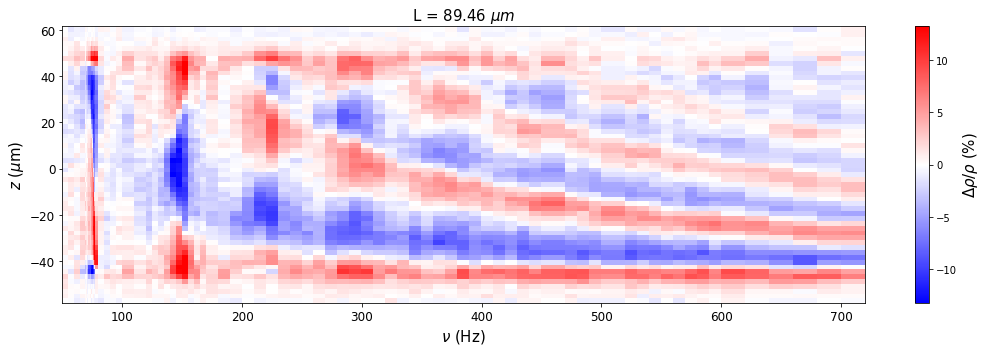

In [197]:
# Movies 
movie = np.array([r.dn.trim(plot_zlim * 1e-6).y / r['box fit bg']['amp'] * 100 for x,r in df_data.iterrows()]).T
movie = [df_data.index.values, df_data.iloc[0]['dn'].trim(plot_zlim * 1e-6).x * 1e6, movie]

# Plots 
clim_movie = np.max(np.abs(movie[2])) * 0.7
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(movie), cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SonogramMovie_bwr.pdf')

# Fourier Components 

In [198]:
# Used Functions 

def discrete_modes_v1(x, L=1, phase=0, a0=0, grad=0, a1=0, a2=0, 
                      a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0, a11=0, a12=0, 
                      a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (cos), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.cos(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.cos(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.cos(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.cos(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.cos(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.cos(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.cos(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.cos(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.cos(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v2(x, L=1, a0=0, grad=0, a1=0, p1=0, 
                   a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (cos): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.cos(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.cos(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.cos(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.cos(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.cos(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.cos(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.cos(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.cos(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.cos(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y

def discrete_modes_v3(x, L=1, phase=0, a0=0, grad=0, 
                      a1=0, a2=0, a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0,
                      a11=0, a12=0, a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (sin, cos, ...), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.sin(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.sin(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.sin(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.sin(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.sin(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.sin(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.sin(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.sin(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.sin(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v4(x, L=1, a0=0, grad=0, 
                   a1=0, p1=0, a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (sin, cos, ...): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.sin(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.sin(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.sin(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.sin(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.sin(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.sin(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.sin(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.sin(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.sin(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y



## fourier transform with cropped L

In [199]:
# Start a figure folder 
display(savefig)
suffix_ft = os.path.join(folder_name, 'FT Centered Cropped','')
os.makedirs(os.path.join(suffix_ft), exist_ok=True)
suffix_ft

A Jupyter Widget

'09-13-2017_19_14_BoxShaking/FT Centered Cropped/'

In [200]:
shift = 0
if zero_z == 'center': shift -= Lum/2
elif zero_z == 'top': shift -= Lum
fit_zlim = (np.array([0 + 0, Lum - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum, 100) + shift

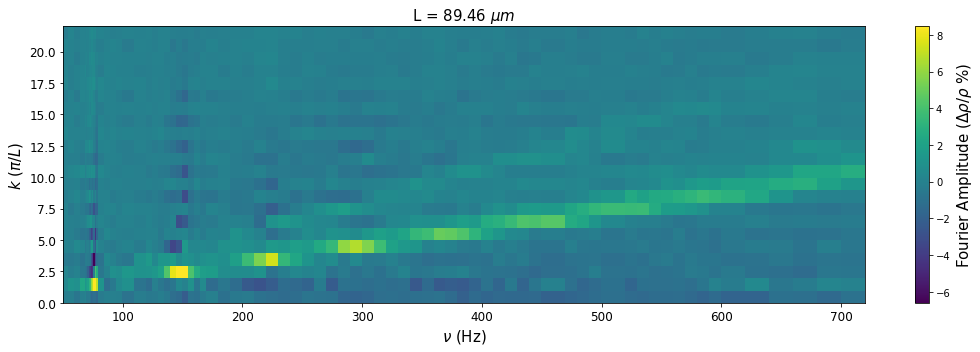

In [224]:
# Compute FT 
kscale = np.pi/(Lum * 1.07)
k = np.arange(0, 22 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(*c.trim(xlim=fit_zlim).plotdata, k)[1] for c in df_data['dn/n']]).T
ft *= 2 * kscale / np.pi
ft_real = [df_data.index.values, k/kscale, np.real(ft)]
ft_imag = [df_data.index.values, k/kscale, np.imag(ft)]
ft_abs = [df_data.index.values, k/kscale, np.abs(ft)]

sign = np.array([1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,])
sign = np.meshgrid(np.ones(ft.shape[1]), sign[:ft.shape[0]])[1]
mult = np.meshgrid(np.ones(ft.shape[1]), np.arange(ft.shape[0]))[1]
# ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]
ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]

# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.75
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'FourierAmpsMovie_viridis.pdf')

In [218]:
# Lorentzian Fit Info 
mode_num = np.array([1,2,3,4,5,6,7,8,9])
ref_freq_guess = 72
gamma_guess = mode_num * 10

fit_lims_width = [50, 50, 60, 120, 150, 240, ]
fit_lims = {'1' : [0, 120], '2':[90, 230], '3':[90, 380], '4':[180, 440], 
            '5':[100,700], '6' : [100, 1000], '7':[100,1000], '8':[100,1000],
            '9':[100,1000], '10':[100,1000]}
# fit_lims = {}

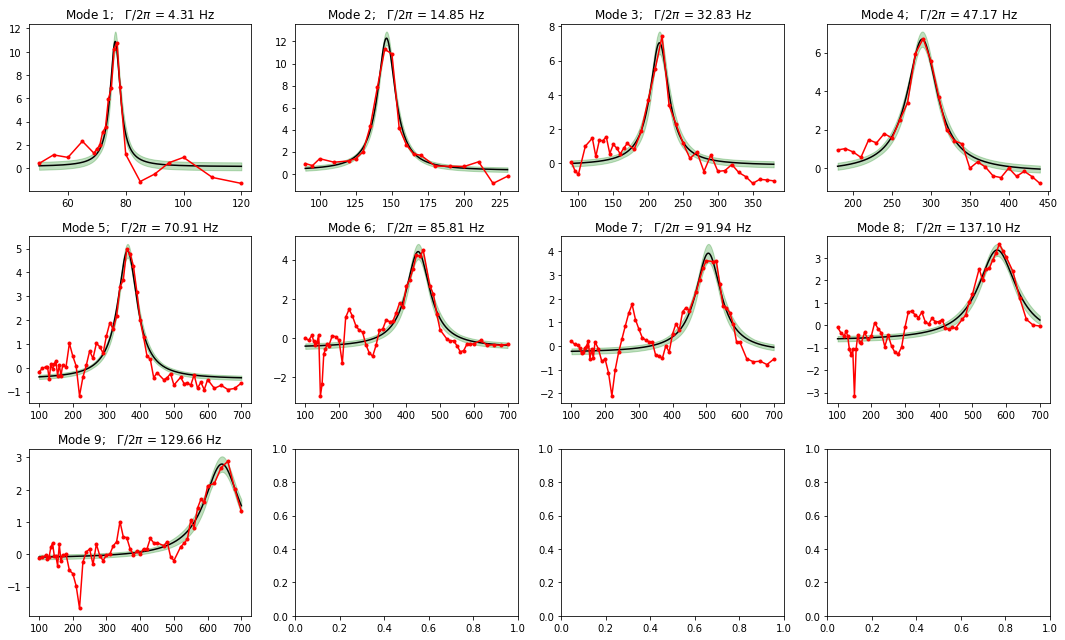

In [219]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1, offset=0)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

ax = plt.subplots(ncols=4, nrows=3, figsize=[15,9])[1].flatten()

for i,m in enumerate(mode_fits):
    m.plot_fiterrors(ax=ax[i])
    ax[i].set(title=r'Mode {};   $\Gamma/2\pi$ = {:.2f} Hz'.format(mode_num[i], abs(m['gamma'])))
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'LorentzianFits.pdf')

In [220]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['k (1/m) error'] = 0
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['FT amplitude (%)'] = [cf['amp'] for cf in mode_fits]
modes['FT amplitude (%) error'] = [cf.fe['amp'] for cf in mode_fits]
modes = modes.set_index('mode num', drop=False)

if savefig.value: modes.to_excel(suffix_ft + 'modes_results.xlsx')
modes

,mode num,k (1/m),k (1/m) error,f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,gamma (Hz),gamma (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (%),FT amplitude (%) error
mode num,,,,,,,,,,,,,,,
1,1,35117.487461,0,76.354614,0.177007,76.354614,0.177007,479.750191,1.112165,4.309661,0.638356,27.078400,4.010909,10.745722,0.858316
2,2,70234.974923,0,146.221320,0.371025,73.110660,0.185512,918.735651,2.331219,14.853271,1.286516,93.325853,8.083419,12.023031,0.607088
3,3,105352.462384,0,216.217864,1.487349,72.072621,0.495783,1358.536904,9.345290,32.827905,5.152185,206.263810,32.372135,7.156126,0.658009
4,4,140469.949846,0,288.800182,1.334080,72.200045,0.333520,1814.585057,8.382270,47.168371,5.130056,296.367619,32.233094,6.912457,0.398860
5,5,175587.437307,0,362.313876,1.891066,72.462775,0.378213,2276.485224,11.881920,70.908146,6.581089,445.529019,41.350204,5.387574,0.288950
6,6,210704.924769,0,434.911294,3.613783,72.485216,0.602297,2732.628254,22.706066,85.807428,12.115115,539.143971,76.121514,4.911338,0.394855
7,7,245822.412230,0,506.129245,3.822983,72.304178,0.546140,3180.103833,24.020512,91.943197,14.480871,577.696145,90.985995,4.202465,0.393164
8,8,280939.899692,0,573.470098,5.167221,71.683762,0.645903,3603.218892,32.466608,137.104248,18.288724,861.451396,114.911443,4.032265,0.266362
9,9,316057.387153,0,642.364157,5.593576,71.373795,0.621508,4036.093036,35.145474,129.660763,19.277357,814.682599,121.123204,2.920183,0.240433


     FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a1   0.245515  0.018846  None      1        -inf         inf   7.676148
a0 -21.247737  6.202075  None      0        -inf         inf  29.189346
    FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a2  0.000077  0.000008  None      1        -inf         inf   9.888254


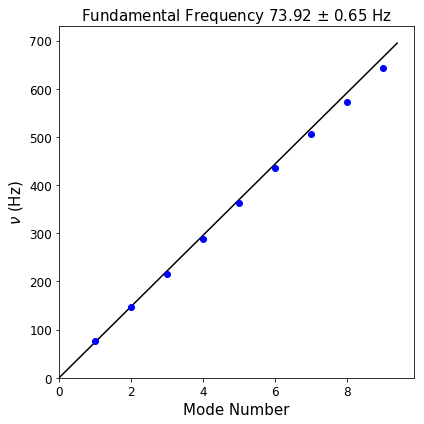

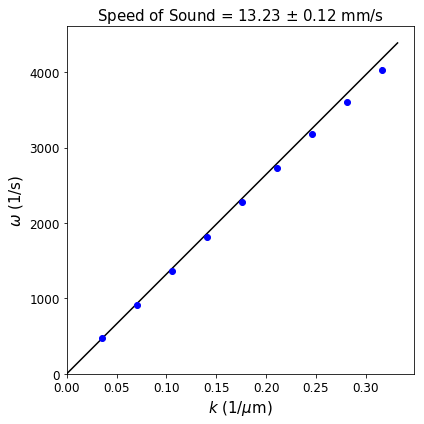

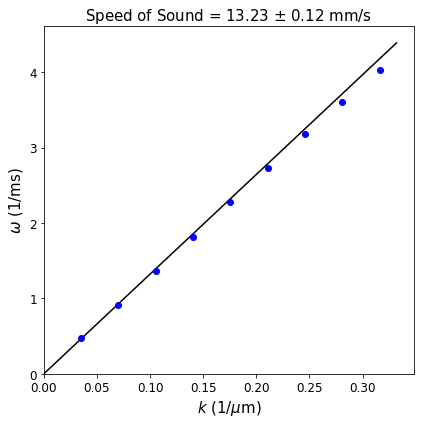

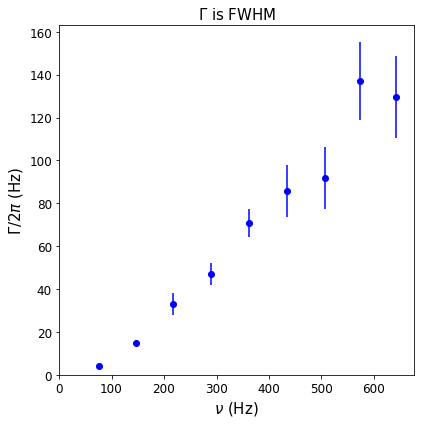

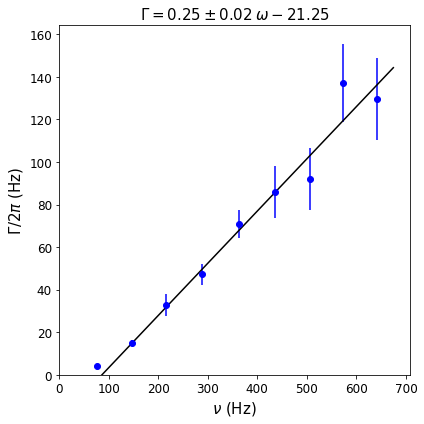

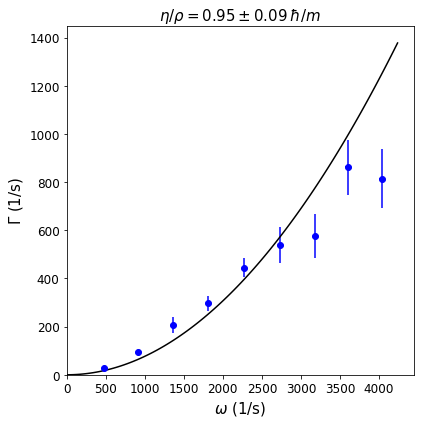

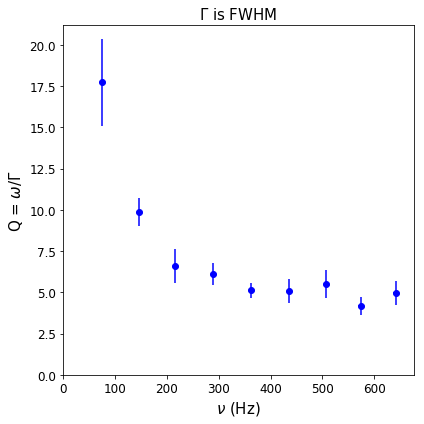

In [221]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode num'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'FundamentalFrequency_v1.pdf')

# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v1.pdf')

# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v2.pdf')

# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v1.pdf')

# Plot Gamma vs Omega with Linear Fit
modes_ = modes.iloc[2:]
cf = tp.curve_fit(lambda x, a1=0, a0=0: a0 + a1 * x, [1,0], modes_['f (Hz)'], modes_['gamma (Hz)'], modes_['gamma (Hz) error'], info=True)
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
xp = np.linspace(0, cf.x.max()*1.05, 100)
plt.plot(xp, cf(xp), 'k-')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma = {:.2f} \pm {:.2f} \: \omega - {:.2f}$'.format(cf[0], cf.fe[0], -cf[1]), fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v2.pdf')
    
# Plot Gamma vs Omega with Quadratic Fit 
cf = tp.curve_fit(lambda x, a2=0: a2*x**2, [1], modes['w (1/s)'], modes['gamma (1/s)'], modes['gamma (1/s) error'], info=True)
speed = dict_data['speed fit'][0] * 1e-6
eta_rho = [3/4 * cf[0] * speed**2 * cst.mass / cst.hbar, 3/4 * cf.fe[0] * speed**2 * cst.mass / cst.hbar]
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
xp = np.linspace(0, cf.x.max()*1.05, 100)
plt.plot(xp, cf(xp), 'k-')
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar / m$'.format(*eta_rho), fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v3.pdf')

# Plot Q vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['gamma (Hz)'], xerr=modes['f (Hz) error'], 
             yerr=np.sqrt((modes['f (Hz) error']/modes['gamma (Hz)'])**2 + (modes['gamma (Hz) error'] * modes['f (Hz)']/modes['gamma (Hz)']**2)**2), fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'QVsFreq_v1.pdf')

In [222]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

## Fitting Box Modes 

In [ ]:
shift = 0
if zero_z == 'center': shift -= Lum/2
elif zero_z == 'top': shift -= Lum
fit_zlim = (np.array([0 + 0, Lum - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum, 100) + shift

In [ ]:
# Fitting with discrete box modes 
fit_keys = ['a{}'.format(i) for i in range(21)]
guess = {k:1 for k in fit_keys}
fixed = dict(L = Lum * 1.05, phase=0, )

def compute_ft_box_fits_v1(dn_n):
    cf = tp.curve_fit(discrete_modes_v3, guess, *dn_n.trim(xlim=fit_zlim).plotdata, fixed=fixed)
    return (np.array([[i,cf[k]] for i,k in enumerate(fit_keys)]).T, cf)

def temp(test = 32):
    r = df_data.iloc[test]
    c_fit = r['dn/n'].trim(xlim=fit_zlim)
    c_fit = tp.Curve(*c_fit.plotdata)
    ft, cf = compute_ft_box_fits_v1(r['dn/n'])
    # Plot 
    fig, ax = plt.subplots(ncols=2, figsize=[12,4])
    plt.sca(ax[0])
    plt.plot(*r['dn/n'].plotdata)
    plt.plot(xp, cf(xp))
    plt.axvspan(*fit_zlim*1e6, color='k', alpha=0.05)
    plt.axhline(0, c='k', alpha=0.3)
    plt.axvline(0, c='k', alpha=0.3)
    plt.xlim(plot_zlim)
    amp = np.max(np.abs(c_fit.y)) * 2
    plt.ylim([-amp, amp])
    plt.sca(ax[1])
    plt.bar(*ft)
    plt.tight_layout()
    plt.show()
    
    
    
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

In [ ]:
# Compute ft 
ft = [df_data.index.values, np.arange(len(fit_keys)), 
      np.array([compute_ft_box_fits_v1(c)[0][1] for c in tqdm(df_data['dn/n'])]).T]

# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.5
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmin=-clim_ft, vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()

In [ ]:
# Lorentzian Fit Info 
mode_num = np.array([1,2,3,4,5,6,7])
ref_freq_guess = 75
gamma_guess = mode_num * 10

fit_lims = {'1' : [0, 100], '2':[90, 200], '3':[130, 300], '4':[150, 500], '5':[200,600], '6' : [320, 560], '7':[200,700]}
fit_lims = {'1' : [0, 100], '2':[100, 200], '3':[130, 300], '4':[170, 500], }

In [ ]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1,)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 4):
    ax = mode_fits[test].plot(fiterrors=False)
    ax[0].set_title('mode num {}'.format(mode_num[test]))
    plt.sca(ax[0])
#     if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
w = ipywidgets.interact(temp, test=(0, len(mode_num)-1))

In [ ]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]

modes

In [ ]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode num'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [ ]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [ ]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

## Fitting Box Modes - SHGs only

# One Sided Spatial Decay

In [ ]:
# Compute df_data 


In [ ]:
1/2 * cst.mass * (0.043)**2 / kHz